# Classification Feature Importances

## Setup

### Library Imports

In [1]:
import os, re
from pathlib import Path

### Path Dictionary

In [2]:
path = {'root': Path(os.getcwd()).parent}

tile, selection = 'cviel', '100k20x3_2'
# tile, selection = 'cviel', '100k20x3'

path['features'] = Path(path['root'], 'classification', 'features')
tilesamples = Path(path['features'], 'samples', tile)
path['samples'] = Path(tilesamples, selection, f'{selection}.parquet')

path['allpoints'] = Path(tilesamples, 'allpoints', f'allpoints.parquet')
path['centroids'] = Path(tilesamples, 'centroids', f'centroids.parquet')

path['results'] = Path(path['features'], 'results', tile, selection)
path['search'] = Path(path['results'], 'search')

path['nom_path'] = Path(path['root'], 'vector_data', 'nomenclature', 'nomenclature_revue_v1.csv')
path

{'root': PosixPath('/work/OT/biomass/tharen/forest-mapping'),
 'features': PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/features'),
 'samples': PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/features/samples/cviel/100k20x3_2/100k20x3_2.parquet'),
 'allpoints': PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/features/samples/cviel/allpoints/allpoints.parquet'),
 'centroids': PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/features/samples/cviel/centroids/centroids.parquet'),
 'results': PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/features/results/cviel/100k20x3_2'),
 'search': PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/features/results/cviel/100k20x3_2/search'),
 'nom_path': PosixPath('/work/OT/biomass/tharen/forest-mapping/vector_data/nomenclature/nomenclature_revue_v1.csv')}

In [3]:
import pandas as pd
nompd = pd.read_csv(path['nom_path'], sep=';')

remove = [14, 15]
codes = nompd[nompd.consid==1 & ~nompd.CODE_merge.isin(remove)][['CODE_merge', 'Name_merge', 'Description_en']]
codes['Description_en'] = codes.groupby(['CODE_merge', 'Name_merge'])['Description_en'].transform(lambda x: ', '.join(x))
codes = codes.drop_duplicates()

# Manually edit descriptions
codes.loc[18, 'Description_en'] = 'Larix decidua and Mixed coniferous forest'
codes.loc[23, 'Description_en'] = 'Mix of deciduous and coniferous'

codes

CODE_merge Name_merge                                   Description_en
2            3        CHE                                   Deciduous oaks
3            9     FF_div    Evergreen oaks, Beech, Mixed deciduous forest
5            6        CHT                                        Chessnuts
6            7        ROB                             Robinia pseudoacacia
10          11         PM                                    Maritime pine
11          12         PS                                       Scots pine
12          17        PIN  Pinus nigra, Other pure pine, Mixed pine forest
13          17         PH                                 Pinus halepensis
14          17         PC                  Pinus uncinata and pinus cembra
17          18      SP_EP                                    Fir or Spruce
18          23     FC_div        Larix decidua and Mixed coniferous forest
19          20        DOU                                      Douglas fir
23          25      F_mix                  Mix of deciduous and coniferous
29          30        PEU                               Populus plantation

In [4]:
prefix = 'code_'

nomenclature = {}
nomenclature['codes'] = dict(zip([f'{prefix}{code}' for code in codes.CODE_merge], codes.Name_merge))
nomenclature['abbrv'] = dict(zip(codes.Name_merge, codes.Description_en))
nomenclature

{'codes': {'code_3': 'CHE',
  'code_9': 'FF_div',
  'code_6': 'CHT',
  'code_7': 'ROB',
  'code_11': 'PM',
  'code_12': 'PS',
  'code_17': 'PC',
  'code_18': 'SP_EP',
  'code_23': 'FC_div',
  'code_20': 'DOU',
  'code_25': 'F_mix',
  'code_30': 'PEU'},
 'abbrv': {'CHE': 'Deciduous oaks',
  'FF_div': 'Evergreen oaks, Beech, Mixed deciduous forest',
  'CHT': 'Chessnuts',
  'ROB': 'Robinia pseudoacacia',
  'PM': 'Maritime pine',
  'PS': 'Scots pine',
  'PIN': 'Pinus nigra, Other pure pine, Mixed pine forest',
  'PH': 'Pinus halepensis',
  'PC': 'Pinus uncinata and pinus cembra',
  'SP_EP': 'Fir or Spruce',
  'FC_div': 'Larix decidua and Mixed coniferous forest',
  'DOU': 'Douglas fir',
  'F_mix': 'Mix of deciduous and coniferous',
  'PEU': 'Populus plantation'}}

## Setup Pipeline

In [5]:
# import rfpimp
import pickle
import dask.dataframe as dd

from modules.classification import Classification, ConfusionMatrix, RFVisualisation
cl = Classification(verbose=True)

In [6]:
from dask.distributed import Client

client = Client(processes=False)
client

<Client: 'inproc://10.120.43.22/81496/1' processes=1 threads=16, memory=64.42 GB>

In [7]:
allcolumns = dd.read_parquet(path['samples']).columns
# print('\"', *sorted({c[3:] for c in allcolumns if 'code' not in c}), '\"', sep='\",\n\"')

In [8]:
s2_bands = ["B2:Blue:490", "B3:Green:560", "B4:Red:670", "B5:Vegetation red edge:705", "B6:Vegetation red edge:740", "B7:Vegetation red edge:780", "B8:NIR:820", "B8A:Narrow NIR:865", "B11:SWIR:1650", "B12:SWIR:2200"]
gray_stats = ["Gray:Kurtosis", "Gray:Mean", "Gray:Skewness", "Gray:Variance",]

o_indices = ["Soil:BI2", "Vegetation:NDRE", "Vegetation:NDVI", "Water:NDWI",]

bi_all_stats = ["BI2:Kurtosis", "BI2:Mean", "BI2:Skewness", "BI2:Variance",]
ndre_all_stats = ["NDRE:Kurtosis", "NDRE:Mean", "NDRE:Skewness", "NDRE:Variance",]
ndvi_all_stats = ["NDVI:Kurtosis", "NDVI:Mean", "NDVI:Skewness", "NDVI:Variance",]
ndwi_all_stats = ["NDWI:Kurtosis", "NDWI:Mean", "NDWI:Skewness", "NDWI:Variance",]

o_ind_all_stats = bi_all_stats + ndre_all_stats + ndvi_all_stats + ndwi_all_stats
o_ind_stats = ["BI2:Mean", "BI2:Variance",
                "NDRE:Mean", "NDRE:Variance",
                "NDVI:Mean", "NDVI:Variance",
                "NDWI:Mean", "NDWI:Variance",]

sar_bands = ["vh_asc", "vh_des", "vv_asc", "vv_des",]
sar_stats = ["vh_asc:Mean", "vh_asc:Variance",
                "vh_des:Mean", "vh_des:Variance",
                "vv_asc:Mean", "vv_asc:Variance",
                "vv_des:Mean", "vv_des:Variance",]
sar_all_stats = ["vh_asc:Kurtosis", "vh_asc:Mean", "vh_asc:Skewness", "vh_asc:Variance",
                "vh_des:Kurtosis", "vh_des:Mean", "vh_des:Skewness", "vh_des:Variance",
                "vv_asc:Kurtosis", "vv_asc:Mean", "vv_asc:Skewness", "vv_asc:Variance",
                "vv_des:Kurtosis", "vv_des:Mean", "vv_des:Skewness", "vv_des:Variance",]
sar_indices = ["SAR:RVI:ASC", "SAR:RVI:DES", "SAR:VH/VV:ASC", "SAR:VH/VV:DES",]

## Model Classification

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score

import numpy as np
import joblib

import tensorflow.keras as keras
from scikeras.wrappers import KerasClassifier

In [10]:
def rf_classifier(modelargs={}):
    return RandomForestClassifier(oob_score=True, n_jobs=-1, **modelargs)

def sharkrf_classifier(modelargs={}):
    return RandomForestClassifier(n_estimators=100, 
                                 min_samples_split=25,
                                 max_features='sqrt',
                                 oob_score=True, max_samples=0.66,
                                 n_jobs=-1, **modelargs)

def add_deep_ffnn(model, dense_layers, dropout):
    if dense_layers and len(dense_layers):
        for neurons, layers in dense_layers:
            for _ in range(layers):
                model.add(keras.layers.Dense(neurons, activation='relu'))
            if dropout:
                model.add(keras.layers.Dropout(dropout))

def fcn_model(meta, name, dense_layers, dropout):
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]
    
    model = keras.models.Sequential(name=name.replace(' ', '_'))
    
    # Input Layer
    model.add(keras.layers.Dense(n_features_in_, input_shape=X_shape_[1:], activation='relu'))
    if dropout:
        model.add(keras.layers.Dropout(dropout))
    
    add_deep_ffnn(model, dense_layers, dropout)
    
    # Output Layer
    model.add(keras.layers.Dense(n_classes_, activation='softmax'))
    return model

def get_model_fcn(resultspath, description, dense_layers, dropout, 
                  datetime=False, **modelargs):
    
    f_name = '-'.join(
        [f'{neurons}x{layers}' for neurons, layers in dense_layers])
    if dropout:
        f_name += f'-Dropx{dropout}'
    
    callback_parameters = cl.default_callbacks(f_name, resultspath, datetime, 
                                               default_name=description)
    description, modelpath, callbacks = callback_parameters
    
    classifier = KerasClassifier(fcn_model,
                           name=description,
                           dense_layers=dense_layers,
                           dropout=dropout,
                           epochs=1000, # Remember stops earlier by callback..
                           optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'],
                           callbacks=callbacks,
                           **modelargs)
    
    return description, modelpath, classifier

def cnn_model(meta, name, conv_filters, dense_layers, dropout):
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]
    
    model = keras.models.Sequential(name=name.replace(' ', '_'))
    
    # Input Layer    
    model.add(keras.layers.Conv1D(conv_filters[0], kernel_size=3, input_shape=X_shape_[1:], activation='relu'))
    model.add(keras.layers.Conv1D(conv_filters[1], kernel_size=3, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Flatten())
    
    add_deep_ffnn(model, dense_layers, dropout)
    
    # Output Layer
    model.add(keras.layers.Dense(n_classes_, activation='softmax'))
    return model

def get_model_cnn(resultspath, description, conv_filters, dense_layers, dropout, 
                  datetime=False, **modelargs):
    
    f_name = 'F'.join([f'{f}' for f in conv_filters]) + 'F'
    if dense_layers:
        f_name += '-'
        f_name += 'D'.join([f'{neurons}x{layers}' 
                            for neurons, layers in dense_layers]) + 'D'
    if dropout:
        f_name += f'-Dropx{dropout}'
    
    callback_parameters = cl.default_callbacks(f_name, resultspath, datetime, 
                                               default_name=description)
    description, modelpath, callbacks = callback_parameters
    
    classifier = KerasClassifier(cnn_model,
                           name=description,
                           conv_filters=conv_filters,
                           dense_layers=dense_layers,
                           dropout=dropout,
                           epochs=1000, # Remember stops earlier by callback..
                           optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'],
                           callbacks=callbacks,
                           **modelargs)
    
    return description, modelpath, classifier

def lstm_model(meta, name, units, dense_layers, dropout):
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]
    
    model = keras.models.Sequential(name=name.replace(' ', '_'))
    
    # Input Layer
    model.add(keras.layers.LSTM(units, input_shape=X_shape_[1:]))
    if dropout:
        model.add(keras.layers.Dropout(dropout))
    
    add_deep_ffnn(model, dense_layers, dropout)
    
    # Output Layer
    model.add(keras.layers.Dense(n_classes_, activation='softmax'))
    return model

def get_model_lstm(resultspath, description, units, dense_layers, dropout, 
                  datetime=False, **modelargs):
    
    f_name = f'{units}U'
    if dense_layers:
        f_name += '-'
        f_name += 'D'.join([f'{neurons}x{layers}' 
                            for neurons, layers in dense_layers]) + 'D'
    if dropout:
        f_name += f'-Dropx{dropout}'
    
    callback_parameters = cl.default_callbacks(f_name, resultspath, datetime, 
                                               default_name=description)
    description, modelpath, callbacks = callback_parameters
    
    classifier = KerasClassifier(lstm_model,
                           name=description,
                           units=units,
                           dense_layers=dense_layers,
                           dropout=dropout,
                           epochs=1000, # Remember stops earlier by callback..
                           optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'],
                           callbacks=callbacks,
                           **modelargs)
    
    return description, modelpath, classifier

def configure_scikeras(description, classifier, modelargs={},
                       resultspath=path['results'], **config):
    
    model_parameters = classifier(resultspath, description, **modelargs)
    description, modelpath, classifier = model_parameters
    
    config['description'] = description
    config['classifier'] = classifier
    config['modelpath'] = modelpath
    config['resultspath'] = resultspath
    return config

In [17]:
def get_evaluation_result(datadict):
    # datalabels = ['model', 'description', 'validation', 'splits', 'featcols', 'report', 'confmat', 'pickle']
    X_train, X_test, y_train, y_test = list(map(lambda s: s.shape, datadict['splits']))
    
    report = datadict['report']
    mean_cv, std_cv = report['cv']['mean'], report['cv']['std']
    overall_acc, kappa, weighted_f1 = report['accuracy'], report['kappa'], report['weighted avg']['f1-score']
    cl.vprint()
    return {
        'description': datadict['description'], 'validation': datadict['validation'],
        'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test,
        'overall_acc': overall_acc, 'kappa': kappa, 'weighted_f1': weighted_f1,
        'model_type': datadict['model_type'], 'parameters': datadict['parameters'],
        'conf_path': datadict['confmat'], 'model_path': datadict['model'], 
        'pkl_path': datadict['pickle']
    }

def load_result_pickle(pkl_path):
    with open(pkl_path, 'rb') as f:
        evaluation_data = pickle.load(f)
        validation = evaluation_data["validation"]
        validation_type = 'Test Size' if isinstance(validation, (int, float)) else 'Validation'
        cl.vprint(f'{validation_type}:\t{validation}')
            
        splits = list(map(lambda s: s.shape, evaluation_data['splits']))
        cl.vprint(f'Split Shapes:\t{splits}')

        report = evaluation_data['report']
        cl.vprint('Mean: %.3f (Std: %.3f)' % (report['cv']['mean'], report['cv']['std']))
        cl.vprint('Overall: %.3f  Kappa: %.3f' % (report['accuracy'], report['kappa']))
        cl.vprint('Weighted F1-Score: %.3f' % (report['weighted avg']['f1-score']))
        return get_evaluation_result(evaluation_data)

def preprocessing_sample(featureset, allcolumns, sample, imbalance, label, validation, scaler, temporal):
    cols = ['code']+[c for l in featureset for c in allcolumns if c.endswith(l)]
    featuresdf = cl.load_features(sample, cols)
    
    if imbalance is not None:
        featuresdf = cl.resample_features(featuresdf, imbalance)
    else:
        szdf = featuresdf.groupby(by='code').size()
        imbalance = round(szdf.max()/szdf.min(), 1)
            
    splits, featcols, validation = cl.split_features(featuresdf, label, validation, scaler, temporal)
    return splits, featcols, validation, imbalance

def postprocessing_model(model, description, validation, splits, featcols, tileset, imbalance, 
                         temporal, label, total, resultspath, nomenclature, model_path, pkl_path):
    
    # TODO: This is making an assumption that only paths for SciKeras model are given
    model_type = 'SciKeras' if model_path else 'Scikit-Learn'
    
    # Evaluation Metrics
    model, score = cl.evaluate_model(model, *splits, temporal)
    
    # Save Models
    if model_path:
        ## Keras Models can be saved through callbacks, but path is provided
        ### https://www.adriangb.com/scikeras/refs/heads/master/notebooks/
        ###        Basic_Usage.html#4.2-Saving-using-Keras'-saving-methods        
        model_path.parent.mkdir(parents=True, exist_ok=True)
        model.model_.save(model_path)
        
        # Save Model Summary
        summary_path = Path(model_path.parent, f'{model_path.stem}.summary.txt')
        with open(summary_path, 'w') as fh:
            # Pass the file handle in as a lambda function to make it callable
            model.model_.summary(print_fn=lambda x: fh.write(x + '\n'))
        
        # Print Model Summary
        model.model_.summary(print_fn=cl.vprint)
    else: 
        ## Save sklearn model through joblib
        model_path = Path(resultspath, 'models', f'{description}.joblib')
        model_path.parent.mkdir(parents=True, exist_ok=True)
        joblib.dump(model, model_path)
    
    columns, report, true_matrix, pred_matrix = cl.classification_metrics(model, splits, score)
    
    cm_filename = f'{tileset} Confusion Matrix {description}'
    cm_title = f'{cm_filename} (Imbalance {imbalance}, Total Samples {total}, {validation})'
    cm_path = Path(resultspath, 'matrices', f'{cm_filename}.svg')
    cm_path.parent.mkdir(parents=True, exist_ok=True)
    cm = ConfusionMatrix(columns, nomenclature, report, true_matrix, pred_matrix, 
                         cm_path, title=cm_title, prefix=f'{label}_')
    
    pkl_path.parent.mkdir(parents=True, exist_ok=True)
    evaluation_data = {'model': model_path,
                       'model_type': model_type,
                       'parameters': str(model.get_params()),
                       'description': description,
                       'validation': validation,
                       'splits': splits,
                       'featcols': featcols,
                       'report': report, 
                       'confmat': cm_path,
                       'pickle': pkl_path}
    
    with open(pkl_path, 'wb') as f:
        pickle.dump(evaluation_data, f, pickle.HIGHEST_PROTOCOL)
    
    return get_evaluation_result(evaluation_data)

def evaluate_sample(featureset, description, classifier, 
                    sample=path['samples'], scaler=StandardScaler, 
                    validation=0.2, imbalance=None, temporal=False,
                    allcolumns=allcolumns, label='code', tileset='CVieL', 
                    nomenclature=nomenclature, 
                    modelpath=None, resultspath=path['results'], 
                    overwrite=False):
    
    cl.vprint(f'Description:\t{description}')
    
    pkl_path = Path(resultspath, 'pickles', f'{description}.pickle')
    if not overwrite and pkl_path.is_file():
        cl.vprint('Run Exists! Loading from pickle...')
        return load_result_pickle(pkl_path)        
    return False
    preprocess = preprocessing_sample(featureset, allcolumns, sample, imbalance, 
                                      label, validation, scaler, temporal)
    splits, featcols, validation, imbalance = preprocess
    X_train, X_test, y_train, y_test = splits
    
    return postprocessing_model(classifier, description, validation, splits, featcols, 
                                tileset, imbalance, temporal, label, len(X_train)+len(X_test), 
                                resultspath, nomenclature, modelpath, pkl_path)

In [12]:
# confscik = configure_scikeras(**{'featureset': o_ind_stats, 'classifier': get_model_fcn, 'scaler': StandardScaler,
#                                  'modelargs': {'dense_layers': [(128, 1)], 'dropout': None},
#                                  'description': 'Temp S2 indices mean and variance with StandardScaler with FCN',
#                                  'overwrite': True})

# evaluate_sample(**confscik)

In [13]:
# confscik = configure_scikeras(**{'featureset': o_ind_stats, 'classifier': get_model_cnn, 'scaler': StandardScaler, 
#                                  'modelargs': {'conv_filters': (32, 16), 'dense_layers': [], 'dropout': 0},
#                                         'description': 'Temp S2 indices mean and variance with StandardScaler with CNN',
#                                         'overwrite': True, 'temporal': True})

# evaluate_sample(**confscik)

In [14]:
# confscik = configure_scikeras(**{'featureset': o_ind_stats, 'classifier': get_model_lstm, 'scaler': StandardScaler,
#                                  'modelargs': {'units': 64, 'dense_layers': [], 'dropout': 0},
#                                  'description': 'Temp S2 indices mean and variance with StandardScaler with LSTM',
#                                  'overwrite': True, 'temporal': True})

# evaluate_sample(**confscik)

In [15]:
# evaluate_sample(**{'featureset': o_ind_stats, 'description': 'S2 indices mean and variance'})

### Models

In [79]:
evalconfig=[
#     {'featureset': s2_bands, 'description': 'S2 bands'},
#     {'featureset': s2_bands, 'validation': path['centroids'], 'description': 'S2 bands with centroid validation'},
#     {'featureset': s2_bands, 'validation': path['allpoints'], 'description': 'S2 bands with all points validation'},
    {'featureset': o_ind_stats, 'classifier': rf_classifier(), 'description': 'S2 indices mean and variance with RF'},
    {'featureset': o_ind_stats, 'classifier': rf_classifier(), 'validation': path['centroids'], 'description': 'S2 indices mean and variance with centroid validation with RF'},
    {'featureset': o_ind_stats, 'classifier': rf_classifier(), 'validation': path['allpoints'], 'description': 'S2 indices mean and variance with all points validation with RF'},
#     {'featureset': s2_bands, 'scaler': StandardScaler, 'description': 'S2 bands with StandardScaler'},
#     {'featureset': s2_bands, 'validation': path['centroids'], 'scaler': StandardScaler, 'description': 'S2 bands with centroid validation with StandardScaler'},
#     {'featureset': s2_bands, 'validation': path['allpoints'], 'scaler': StandardScaler, 'description': 'S2 bands with all points validation with StandardScaler'},
    {'featureset': o_ind_stats, 'classifier': rf_classifier(), 'scaler': StandardScaler, 'description': 'S2 indices mean and variance with StandardScaler'},
    {'featureset': o_ind_stats, 'classifier': rf_classifier(), 'validation': path['centroids'], 'scaler': StandardScaler, 
     'description': 'S2 indices mean and variance with centroid validation with StandardScaler with RF'},
    {'featureset': o_ind_stats, 'classifier': rf_classifier(), 'validation': path['allpoints'], 'scaler': StandardScaler, 
     'description': 'S2 indices mean and variance with all points validation with StandardScaler with RF'},
#     {'featureset': s2_bands, 'scaler': MinMaxScaler, 'description': 'S2 bands with MinMaxScaler'},
#     {'featureset': s2_bands, 'validation': path['centroids'], 'scaler': MinMaxScaler, 'description': 'S2 bands with centroid validation with MinMaxScaler'},
#     {'featureset': s2_bands, 'validation': path['allpoints'], 'scaler': MinMaxScaler, 'description': 'S2 bands with all points validation with MinMaxScaler'},
#     {'featureset': o_ind_stats, 'scaler': MinMaxScaler, 'description': 'S2 indices mean and variance with MinMaxScaler'},
#     {'featureset': o_ind_stats, 'validation': path['centroids'], 'scaler': MinMaxScaler, 'description': 'S2 indices mean and variance with centroid validation with MinMaxScaler'},
#     {'featureset': o_ind_stats, 'validation': path['allpoints'], 'scaler': MinMaxScaler, 'description': 'S2 indices mean and variance with all points validation with MinMaxScaler'}
]

dense_layers = [[(16, 1)], [(32, 1)], [(64, 1)], [(128, 1)]]
dropout =  [None, .25, .5, .75]

evalkerasconfig = [
    configure_scikeras(**c) 
    for c in [
        c for l in dense_layers for d in dropout 
        for c in [
            {'featureset': o_ind_stats, 'classifier': get_model_fcn, 'modelargs': {'dense_layers': l, 'dropout': d},
             'scaler': StandardScaler, 'description': 'S2 indices mean and variance with StandardScaler with FCN'},
#             {'featureset': o_ind_stats, 'classifier': get_model_fcn, 'modelargs': {'dense_layers': l, 'dropout': d},
#              'scaler': MinMaxScaler, 'description': 'S2 indices mean and variance with MinMaxScaler with FCN'},
#             {'featureset': s2_bands, 'classifier': get_model_fcn, 'modelargs': {'dense_layers': l, 'dropout': d},
#              'scaler': StandardScaler, 'description': 'S2 bands with StandardScaler with FCN'},
#             {'featureset': s2_bands, 'classifier': get_model_fcn, 'modelargs': {'dense_layers': l, 'dropout': d},
#              'scaler': MinMaxScaler, 'description': 'S2 bands with MinMaxScaler with FCN'},
            {'featureset': o_ind_stats, 'classifier': get_model_fcn, 'modelargs': {'dense_layers': l, 'dropout': d}, 'validation': path['allpoints'],
             'scaler': StandardScaler, 'description': 'S2 indices mean and variance with StandardScaler with all points with FCN'},
#             {'featureset': o_ind_stats, 'classifier': get_model_fcn, 'modelargs': {'dense_layers': l, 'dropout': d}, 'validation': path['allpoints'],
#              'scaler': MinMaxScaler, 'description': 'S2 indices mean and variance with MinMaxScaler with all points with FCN'},
#             {'featureset': s2_bands, 'classifier': get_model_fcn, 'modelargs': {'dense_layers': l, 'dropout': d}, 'validation': path['allpoints'],
#              'scaler': StandardScaler, 'description': 'S2 bands with StandardScaler with all points with FCN'},
#             {'featureset': s2_bands, 'classifier': get_model_fcn, 'modelargs': {'dense_layers': l, 'dropout': d}, 'validation': path['allpoints'],
#              'scaler': MinMaxScaler, 'description': 'S2 bands with MinMaxScaler with all points with FCN'},
            {'featureset': o_ind_stats, 'classifier': get_model_fcn, 'modelargs': {'dense_layers': l, 'dropout': d}, 'validation': path['centroids'],
             'scaler': StandardScaler, 'description': 'S2 indices mean and variance with StandardScaler with centroids with FCN'},
#             {'featureset': o_ind_stats, 'classifier': get_model_fcn, 'modelargs': {'dense_layers': l, 'dropout': d}, 'validation': path['centroids'],
#              'scaler': MinMaxScaler, 'description': 'S2 indices mean and variance with MinMaxScaler with centroids with FCN'},
#             {'featureset': s2_bands, 'classifier': get_model_fcn, 'modelargs': {'dense_layers': l, 'dropout': d}, 'validation': path['centroids'],
#              'scaler': StandardScaler, 'description': 'S2 bands with StandardScaler with centroids with FCN'},
#             {'featureset': s2_bands, 'classifier': get_model_fcn, 'modelargs': {'dense_layers': l, 'dropout': d}, 'validation': path['centroids'],
#              'scaler': MinMaxScaler, 'description': 'S2 bands with MinMaxScaler with centroids with FCN'},
        ] 
    ]
]

conv_filters = [(32, 16), (64, 32)]
dense_layers = [None, [(16, 1)], [(32, 1)], [(64, 1)], [(128, 1)]]

evaltemporalkerasconfig = [
    configure_scikeras(**c) 
    for c in [
        c for l in dense_layers for d in dropout for f in conv_filters
        for c in [
            {'featureset': o_ind_stats, 'classifier': get_model_cnn, 'modelargs': {'conv_filters': f, 'dense_layers': l, 'dropout': d},
             'scaler': StandardScaler, 'description': 'S2 indices mean and variance with StandardScaler with CNN'},
            {'featureset': o_ind_stats, 'classifier': get_model_cnn, 'modelargs': {'conv_filters': f, 'dense_layers': l, 'dropout': d}, 'validation': path['allpoints'],
             'scaler': StandardScaler, 'description': 'S2 indices mean and variance with StandardScaler with all points with CNN'},
            {'featureset': o_ind_stats, 'classifier': get_model_cnn, 'modelargs': {'conv_filters': f, 'dense_layers': l, 'dropout': d}, 'validation': path['centroids'],
             'scaler': StandardScaler, 'description': 'S2 indices mean and variance with StandardScaler with centroids with CNN'},
        ] 
    ]
]

units = [4, 16, 64]
dense_layers = [None, [(16, 1)], [(64, 1)]]

evaltemporalkerasconfig += [
    configure_scikeras(**c) 
    for c in [
        c for l in dense_layers for d in dropout for u in units
        for c in [
            {'featureset': o_ind_stats, 'classifier': get_model_lstm, 'modelargs': {'units': u, 'dense_layers': l, 'dropout': d},
             'scaler': StandardScaler, 'description': 'S2 indices mean and variance with StandardScaler with LSTM'},
            {'featureset': o_ind_stats, 'classifier': get_model_lstm, 'modelargs': {'units': u, 'dense_layers': l, 'dropout': d}, 'validation': path['allpoints'],
             'scaler': StandardScaler, 'description': 'S2 indices mean and variance with StandardScaler with all points with LSTM'},
            {'featureset': o_ind_stats, 'classifier': get_model_lstm, 'modelargs': {'units': u, 'dense_layers': l, 'dropout': d}, 'validation': path['centroids'],
             'scaler': StandardScaler, 'description': 'S2 indices mean and variance with StandardScaler with centroids with LSTM'},
        ] 
    ]
]

for c in evaltemporalkerasconfig:
    c['temporal'] = True

evalkerasconfig += evaltemporalkerasconfig
evalconfig += evalkerasconfig
evals = [evaluate_sample(**c) for c in evalconfig]

# cl.set_verbose(False)
results = pd.DataFrame([e for e in evals if e]).sort_values(by='weighted_f1', ascending=False)

def get_name(df): 
    name = [i for i in df.parameters.split(', ') if i.startswith("'name'")]
    if name:
        name = name[0].split(' ')[-1][:-1] 
    else: 
        name = 'with'.join([s for s in df.description.split('with')[1:] if 'validation' not in s])[1:]
        if name == 'StandardScaler': # Handling an input error made before learning RF model
            name = 'StandardScaler with RF'
            
    return name
results.insert(0, 'name', results.apply(get_name, axis=1))

results_path = Path(path['results'], 'results.csv')
results.to_csv(results_path)
# cl.rchmod(results_path, path['features'])
results

Description:	S2 indices mean and variance with RF
Run Exists! Loading from pickle...
Validation:	Split Ratio 0.2
Split Shapes:	[(79997, 96), (20000, 96), (79997, 12), (20000, 12)]
Mean: 0.574 (Std: 0.003)
Overall: 0.508  Kappa: 0.439
Weighted F1-Score: 0.536

Description:	S2 indices mean and variance with centroid validation with RF
Run Exists! Loading from pickle...
Validation:	Validation Set centroids
Split Shapes:	[(99997, 96), (349, 96), (99997, 12), (349, 12)]
Mean: 0.126 (Std: 0.110)
Overall: 0.559  Kappa: 0.439
Weighted F1-Score: 0.528

Description:	S2 indices mean and variance with all points validation with RF
Run Exists! Loading from pickle...
Validation:	Validation Set allpoints
Split Shapes:	[(99997, 96), (1642, 96), (99997, 12), (1642, 12)]
Mean: 0.137 (Std: 0.103)
Overall: 0.589  Kappa: 0.456
Weighted F1-Score: 0.563

Description:	S2 indices mean and variance with StandardScaler
Run Exists! Loading from pickle...
Validation:	Split Ratio 0.2
Split Shapes:	[(79997, 96), (20

name  \
42                 FCN-128x1   
18                  FCN-32x1   
30                  FCN-64x1   
6                   FCN-16x1   
33        FCN-64x1-Dropx0.25   
..                       ...   
183        LSTM-4U-Dropx0.25   
203        LSTM-4U-Dropx0.75   
192         LSTM-4U-Dropx0.5   
219  LSTM-4U-16x1D-Dropx0.25   
201        LSTM-4U-Dropx0.75   

                                           description  \
42   S2 indices mean and variance with StandardScal...   
18   S2 indices mean and variance with StandardScal...   
30   S2 indices mean and variance with StandardScal...   
6    S2 indices mean and variance with StandardScal...   
33   S2 indices mean and variance with StandardScal...   
..                                                 ...   
183  S2 indices mean and variance with StandardScal...   
203  S2 indices mean and variance with StandardScal...   
192  S2 indices mean and variance with StandardScal...   
219  S2 indices mean and variance with StandardScal...   
201  S2 indices mean and variance with StandardScal...   

                   validation         X_train          X_test      y_train  \
42            Split Ratio 0.2     (79997, 96)     (20000, 96)  (79997, 12)   
18            Split Ratio 0.2     (79997, 96)     (20000, 96)  (79997, 12)   
30            Split Ratio 0.2     (79997, 96)     (20000, 96)  (79997, 12)   
6             Split Ratio 0.2     (79997, 96)     (20000, 96)  (79997, 12)   
33            Split Ratio 0.2     (79997, 96)     (20000, 96)  (79997, 12)   
..                        ...             ...             ...          ...   
183           Split Ratio 0.2  (79997, 12, 8)  (20000, 12, 8)  (79997, 12)   
203  Validation Set centroids  (99997, 12, 8)    (349, 12, 8)  (99997, 12)   
192           Split Ratio 0.2  (79997, 12, 8)  (20000, 12, 8)  (79997, 12)   
219           Split Ratio 0.2  (79997, 12, 8)  (20000, 12, 8)  (79997, 12)   
201           Split Ratio 0.2  (79997, 12, 8)  (20000, 12, 8)  (79997, 12)   

          y_test  overall_acc     kappa  weighted_f1 model_type  \
42   (20000, 12)     0.719350  0.682548     0.718838   SciKeras   
18   (20000, 12)     0.718400  0.681220     0.717145   SciKeras   
30   (20000, 12)     0.721400  0.685041     0.716599   SciKeras   
6    (20000, 12)     0.714650  0.677297     0.710233   SciKeras   
33   (20000, 12)     0.708050  0.669272     0.701448   SciKeras   
..           ...          ...       ...          ...        ...   
183  (20000, 12)     0.468250  0.393599     0.436999   SciKeras   
203    (349, 12)     0.432665  0.306309     0.425275   SciKeras   
192  (20000, 12)     0.443300  0.362820     0.424200   SciKeras   
219  (20000, 12)     0.465850  0.390979     0.416266   SciKeras   
201  (20000, 12)     0.360050  0.264806     0.308020   SciKeras   

                                            parameters  \
42   {'model': <function fcn_model at 0x2ab9d3ee344...   
18   {'model': <function fcn_model at 0x2ab9d3ee344...   
30   {'model': <function fcn_model at 0x2ab9d3ee344...   
6    {'model': <function fcn_model at 0x2ab9d3ee344...   
33   {'model': <function fcn_model at 0x2ab9d3ee344...   
..                                                 ...   
183  {'model': <function lstm_model at 0x2addb95f6b...   
203  {'model': <function lstm_model at 0x2b9dd2b98b...   
192  {'model': <function lstm_model at 0x2addb95f6b...   
219  {'model': <function lstm_model at 0x2aedee7d66...   
201  {'model': <function lstm_model at 0x2b9dd2b98b...   

                                             conf_path  \
42   /work/OT/biomass/tharen/forest-mapping/classif...   
18   /work/OT/biomass/tharen/forest-mapping/classif...   
30   /work/OT/biomass/tharen/forest-mapping/classif...   
6    /work/OT/biomass/tharen/forest-mapping/classif...   
33   /work/OT/biomass/tharen/forest-mapping/classif...   
..                                                 ...   
183  /work/OT/biomass/tharen/forest-mapping/classif...   
203  /work/OT/biomass/tharen/forest-map

## Plot

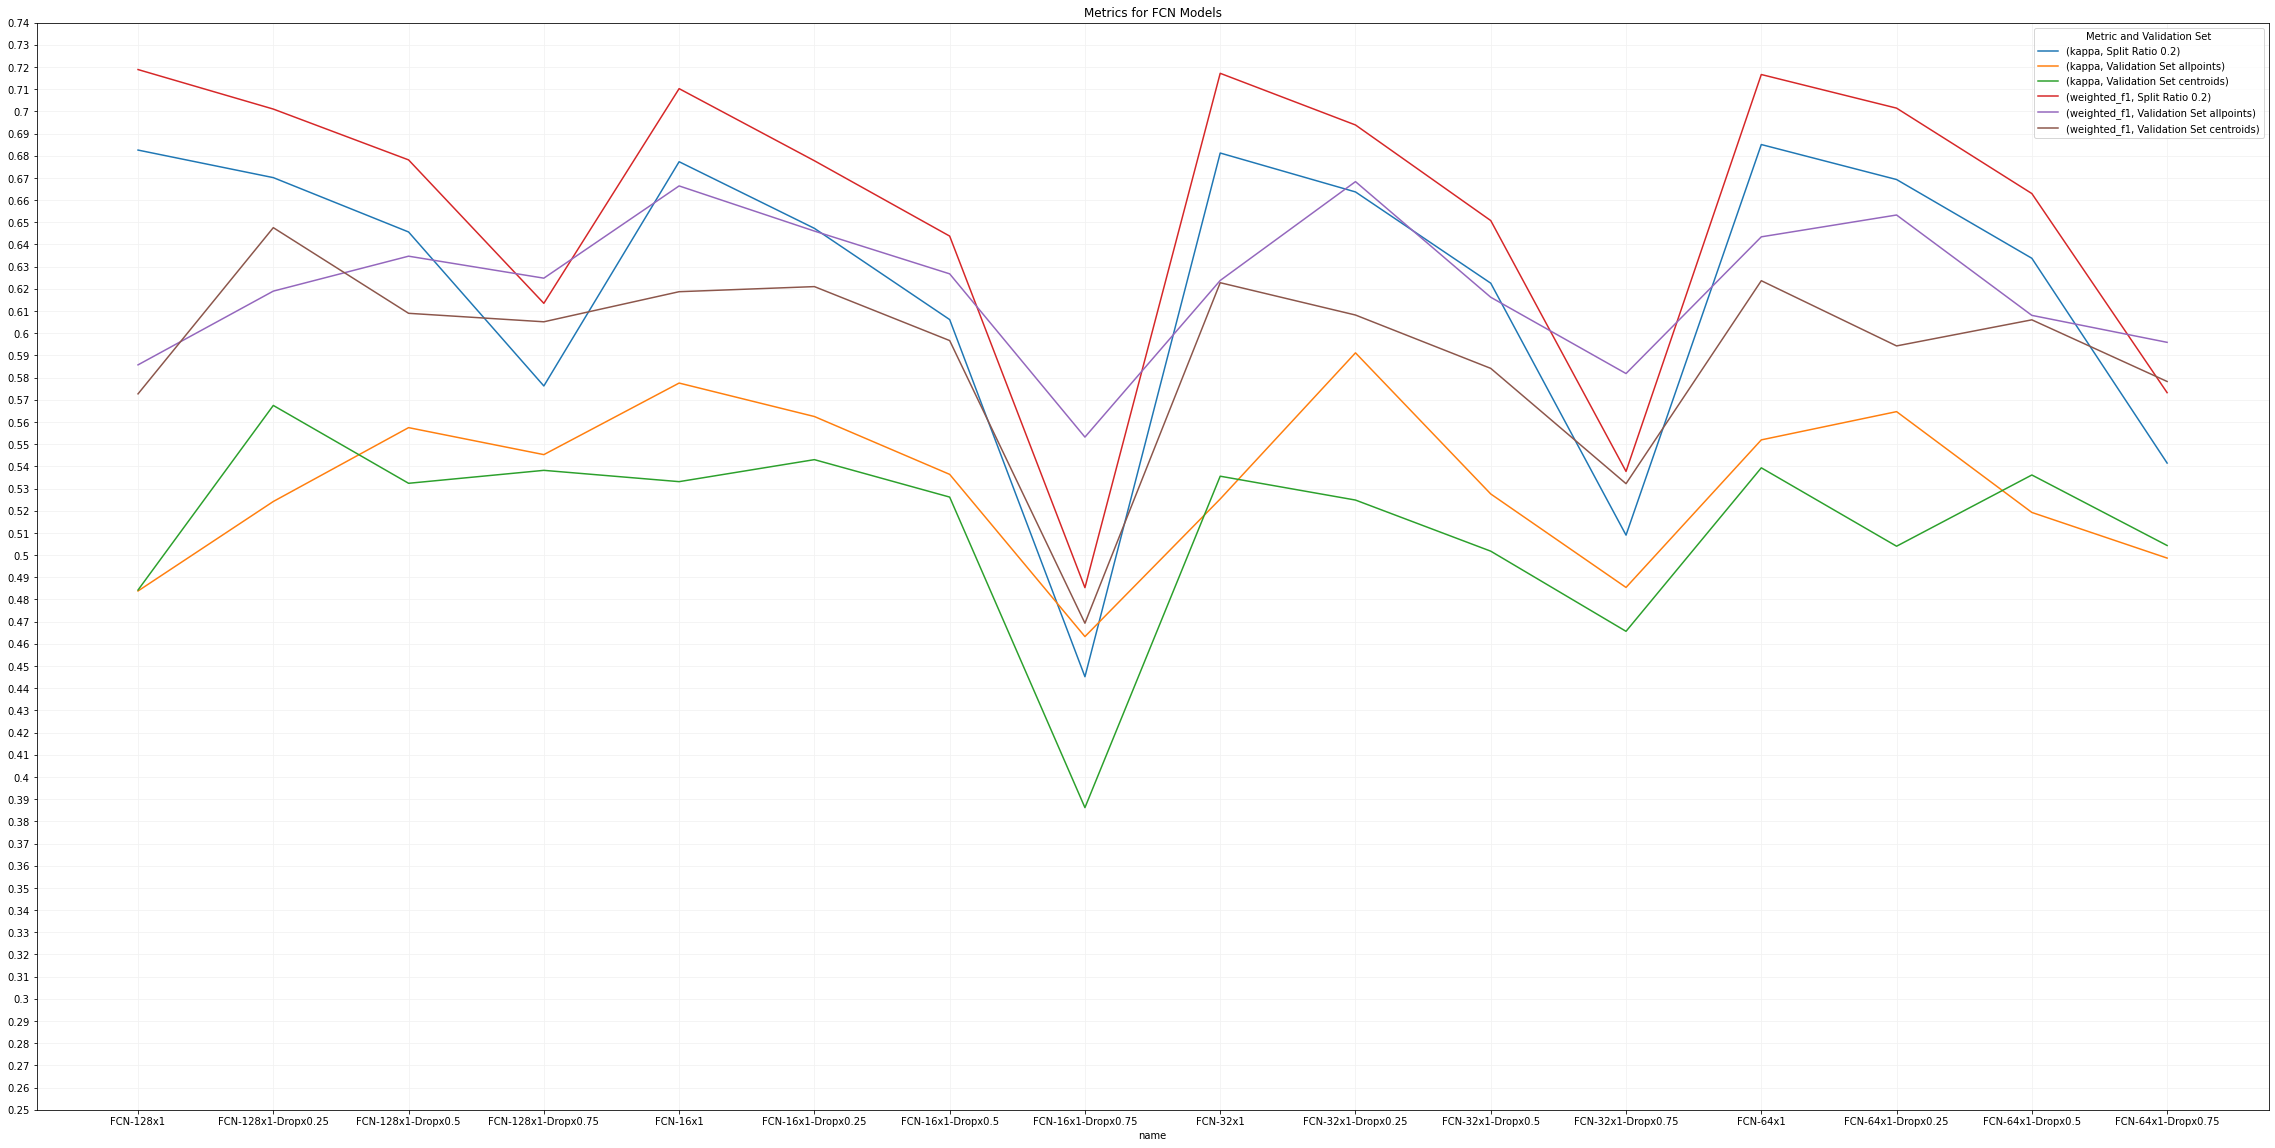

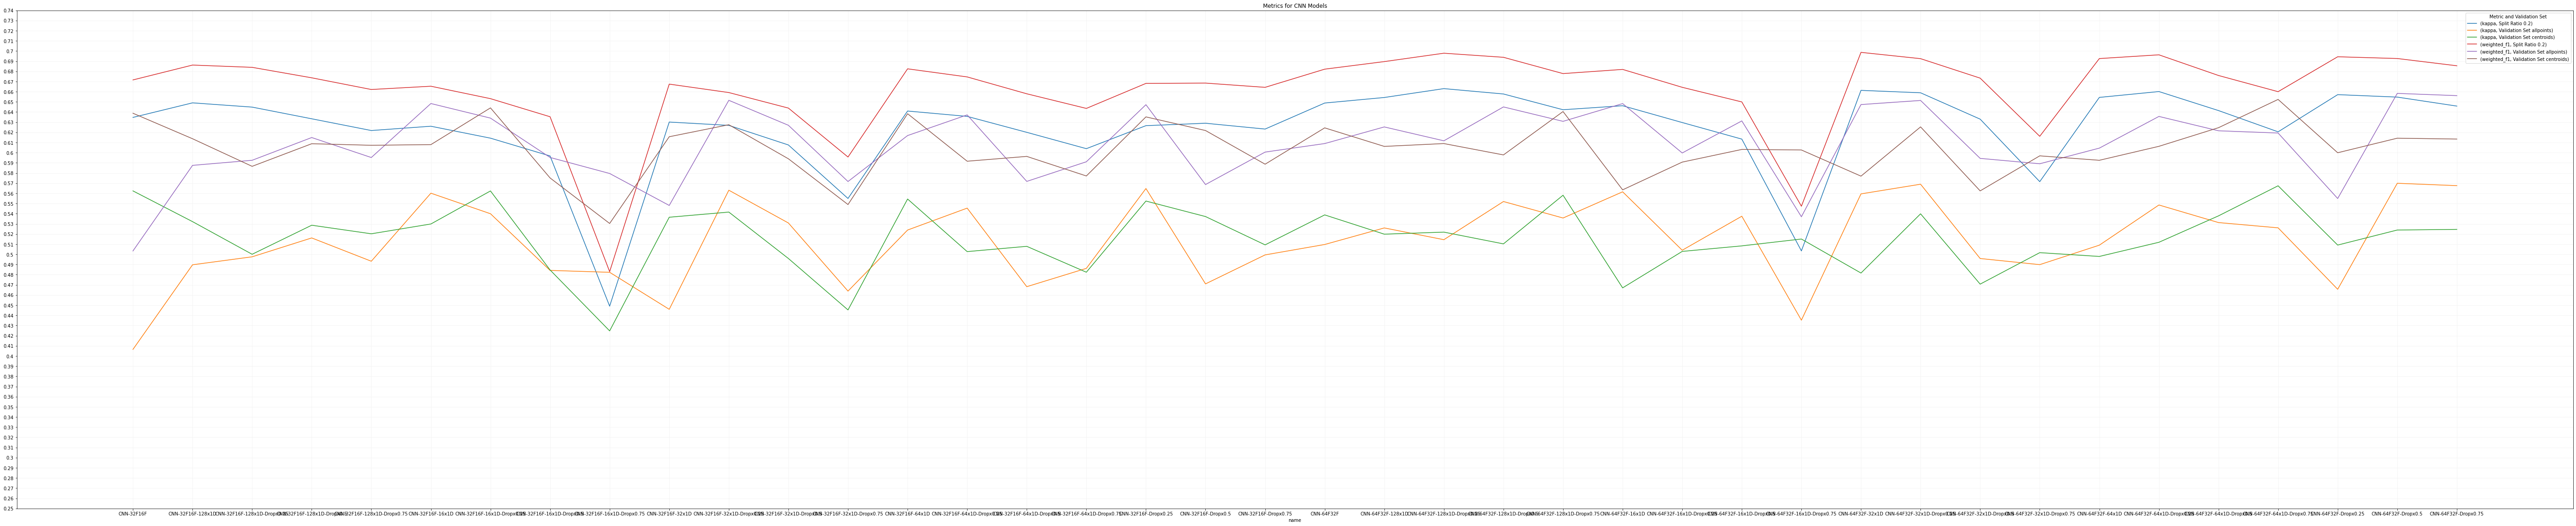

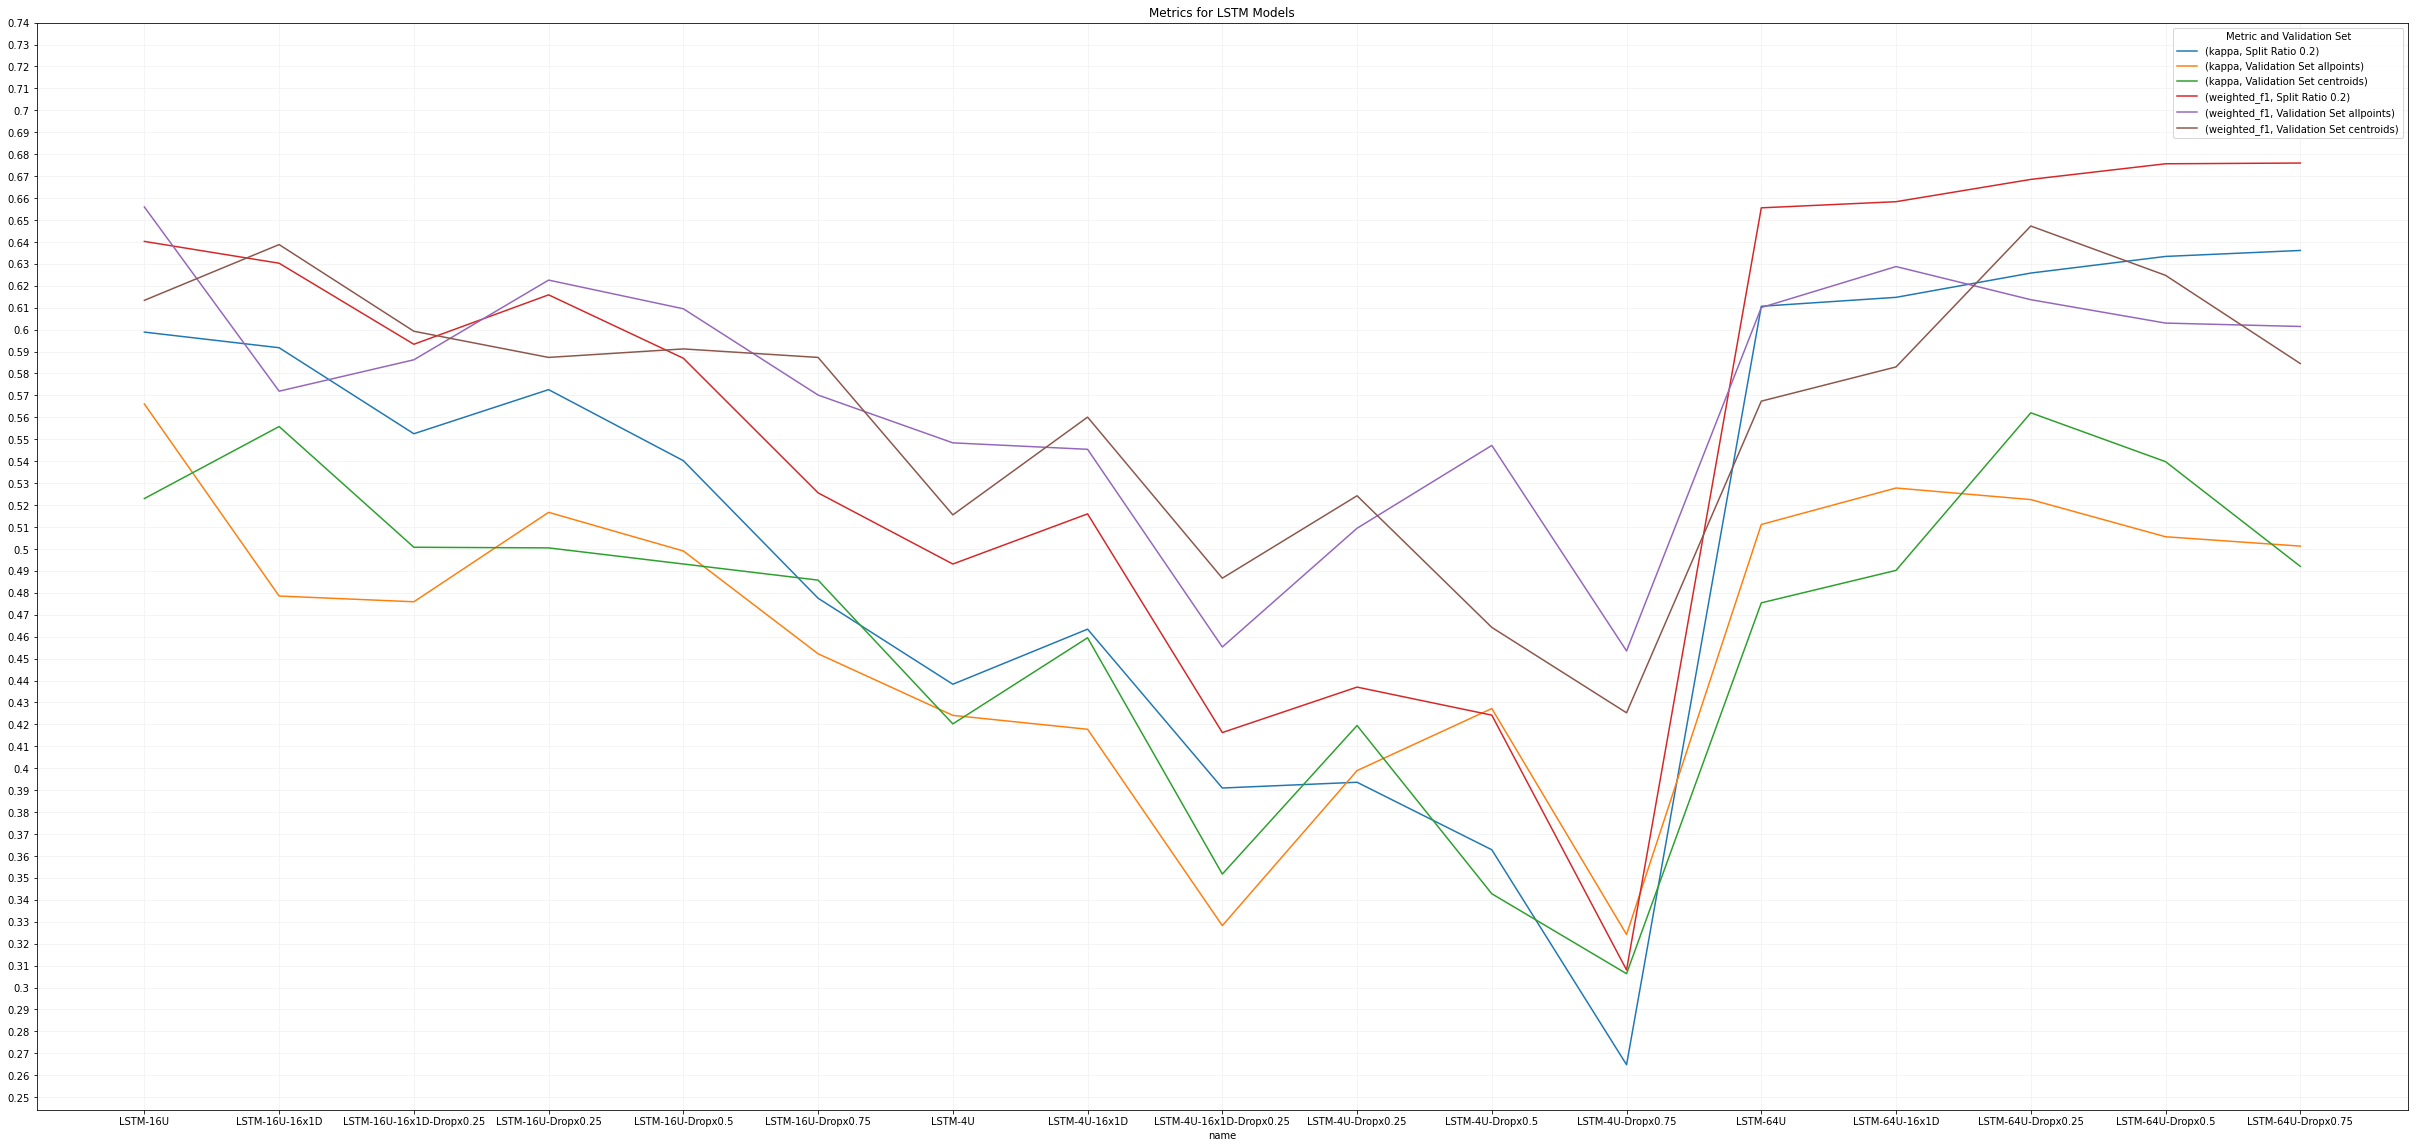

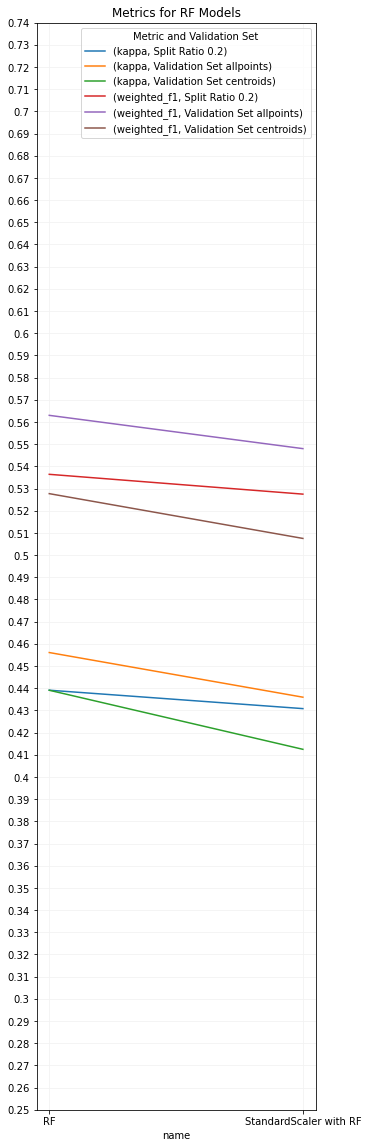

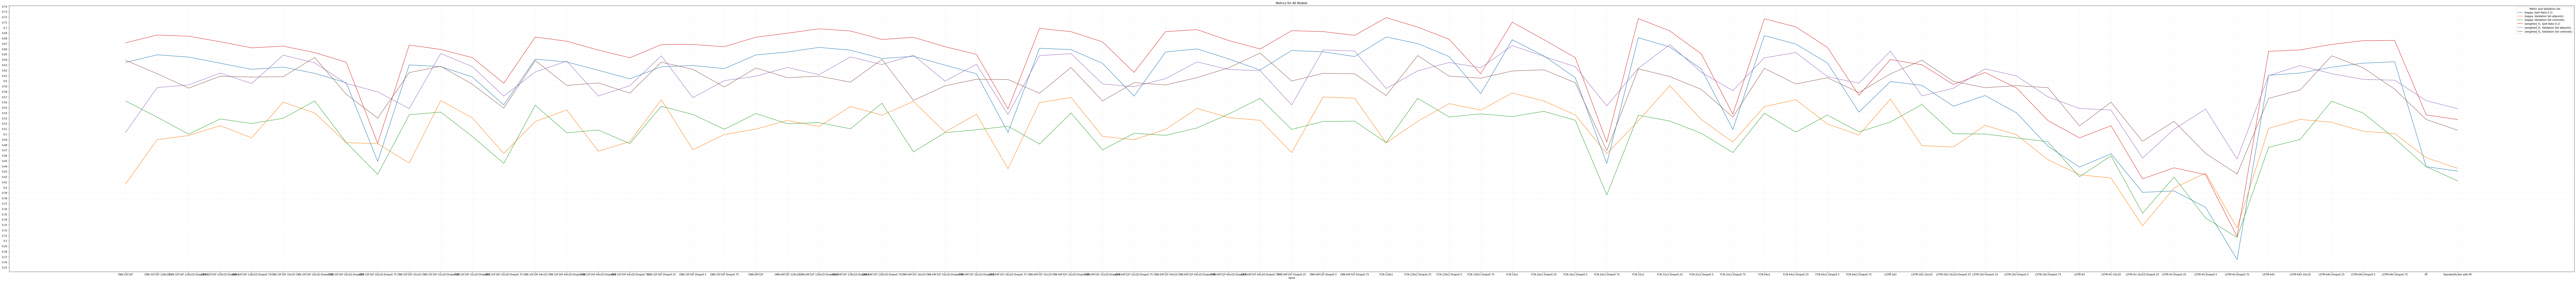

In [146]:
import matplotlib.pyplot as plt

def plot_segment(segment, segment_name):
    df = segment.pivot(index='name', columns='validation', values=['kappa', 'weighted_f1'])
    values = np.round(np.arange(.25, .75, .01), 2)
    labels = len(df)
    ax = df.plot(figsize=(labels*2.5, len(values)/2.5))
    ax.set_yticks(values)
    ax.set_yticklabels(values)
    ax.set_xticks(range(labels))
    ax.set_xticklabels(df.index.values)
    ax.grid(axis='x', color='0.95')
    ax.grid(axis='y', color='0.95')
    
    ax.legend(title='Metric and Validation Set')
    ax.set_title(segment_name)
    plt.savefig(Path(path['results'], f'{segment_name}.svg'), 
                bbox_inches='tight', facecolor='w', edgecolor='w')

plot_segment(results[results.name.str.contains('FCN')], 'Metrics for FCN Models')
plot_segment(results[results.name.str.contains('CNN')], 'Metrics for CNN Models')
plot_segment(results[results.name.str.contains('LSTM')], 'Metrics for LSTM Models')
plot_segment(results[results.name.str.contains('RF')], 'Metrics for RF Models')
plot_segment(results, 'Metrics for All Models')

### Features

In [ ]:
featurespath = Path(path['results'], 'features')

featconfig = [
    {'featureset': s2_bands, 'description': 's2_bands'},
    {'featureset': s2_bands+sar_bands, 'description': 's2_bands+sar_bands'},
    {'featureset': s2_bands+sar_bands+sar_stats, 'description': 's2_bands+sar_bands+sar_stats'},
    {'featureset': s2_bands+sar_bands+sar_all_stats, 'description': 's2_bands+sar_bands+sar_all_stats'},
    {'featureset': s2_bands+sar_bands+sar_indices, 'description': 's2_bands+sar_bands+sar_indices'},
    {'featureset': s2_bands+sar_bands+sar_indices+sar_stats, 'description': 's2_bands+sar_bands+sar_indices+sar_stats'},
    {'featureset': s2_bands+sar_bands+sar_indices+sar_all_stats, 'description': 's2_bands+sar_bands+sar_indices+sar_all_stats'},
    {'featureset': s2_bands+sar_indices, 'description': 's2_bands+sar_indices'},
    {'featureset': s2_bands+sar_indices+sar_stats, 'description': 's2_bands+sar_indices+sar_stats'},
    {'featureset': s2_bands+sar_indices+sar_all_stats, 'description': 's2_bands+sar_indices+sar_all_stats'},
    {'featureset': o_indices, 'description': 'o_indices'},
    {'featureset': o_indices+sar_bands, 'description': 'o_indices+sar_bands'},
    {'featureset': o_indices+sar_bands+sar_stats, 'description': 'o_indices+sar_bands+sar_stats'},
    {'featureset': o_indices+sar_bands+sar_all_stats, 'description': 'o_indices+sar_bands+sar_all_stats'},
    {'featureset': o_indices+sar_bands+sar_indices, 'description': 'o_indices+sar_bands+sar_indices'},
    {'featureset': o_indices+sar_bands+sar_indices+sar_stats, 'description': 'o_indices+sar_bands+sar_indices+sar_stats'},
    {'featureset': o_indices+sar_bands+sar_indices+sar_all_stats, 'description': 'o_indices+sar_bands+sar_indices+sar_all_stats'},
    {'featureset': o_indices+sar_indices, 'description': 'o_indices+sar_indices'},
    {'featureset': o_indices+sar_indices+sar_stats, 'description': 'o_indices+sar_indices+sar_stats'},
    {'featureset': o_indices+sar_indices+sar_all_stats, 'description': 'o_indices+sar_indices+sar_all_stats'},
    {'featureset': o_ind_all_stats, 'description': 'o_ind_all_stats'},
    {'featureset': o_ind_all_stats+sar_bands, 'description': 'o_ind_all_stats+sar_bands'},
    {'featureset': o_ind_all_stats+sar_bands+sar_stats, 'description': 'o_ind_all_stats+sar_bands+sar_stats'},
    {'featureset': o_ind_all_stats+sar_bands+sar_all_stats, 'description': 'o_ind_all_stats+sar_bands+sar_all_stats'},
    {'featureset': o_ind_all_stats+sar_bands+sar_indices, 'description': 'o_ind_all_stats+sar_bands+sar_indices'},
    {'featureset': o_ind_all_stats+sar_bands+sar_indices+sar_stats, 'description': 'o_ind_all_stats+sar_bands+sar_indices+sar_stats'},
    {'featureset': o_ind_all_stats+sar_bands+sar_indices+sar_all_stats, 'description': 'o_ind_all_stats+sar_bands+sar_indices+sar_all_stats'},
    {'featureset': o_ind_all_stats+sar_indices, 'description': 'o_ind_all_stats+sar_indices'},
    {'featureset': o_ind_all_stats+sar_indices+sar_stats, 'description': 'o_ind_all_stats+sar_indices+sar_stats'},
    {'featureset': o_ind_all_stats+sar_indices+sar_all_stats, 'description': 'o_ind_all_stats+sar_indices+sar_all_stats'},
    {'featureset': o_ind_stats, 'description': 'o_ind_stats'},
    {'featureset': o_ind_stats+sar_bands, 'description': 'o_ind_stats+sar_bands'},
    {'featureset': o_ind_stats+sar_bands+sar_stats, 'description': 'o_ind_stats+sar_bands+sar_stats'},
    {'featureset': o_ind_stats+sar_bands+sar_all_stats, 'description': 'o_ind_stats+sar_bands+sar_all_stats'},
    {'featureset': o_ind_stats+sar_bands+sar_indices, 'description': 'o_ind_stats+sar_bands+sar_indices'},
    {'featureset': o_ind_stats+sar_bands+sar_indices+sar_stats, 'description': 'o_ind_stats+sar_bands+sar_indices+sar_stats'},
    {'featureset': o_ind_stats+sar_bands+sar_indices+sar_all_stats, 'description': 'o_ind_stats+sar_bands+sar_indices+sar_all_stats'},
    {'featureset': o_ind_stats+sar_indices, 'description': 'o_ind_stats+sar_indices'},
    {'featureset': o_ind_stats+sar_indices+sar_stats, 'description': 'o_ind_stats+sar_indices+sar_stats'},
    {'featureset': o_ind_stats+sar_indices+sar_all_stats, 'description': 'o_ind_stats+sar_indices+sar_all_stats'},
    {'featureset': o_indices+o_ind_stats+sar_bands, 'description': 'o_indices+o_ind_stats+sar_bands'},
    {'featureset': o_indices+o_ind_stats+sar_bands+sar_stats, 'description': 'o_indices+o_ind_stats+sar_bands+sar_stats'},
    {'featureset': o_indices+o_ind_stats+sar_bands+sar_all_stats, 'description': 'o_indices+o_ind_stats+sar_bands+sar_all_stats'},
    {'featureset': o_indices+o_ind_stats+sar_bands+sar_indices, 'description': 'o_indices+o_ind_stats+sar_bands+sar_indices'},
    {'featureset': o_indices+o_ind_stats+sar_bands+sar_indices+sar_stats, 'description': 'o_indices+o_ind_stats+sar_bands+sar_indices+sar_stats'},
    {'featureset': o_indices+o_ind_stats+sar_bands+sar_indices+sar_all_stats, 'description': 'o_indices+o_ind_stats+sar_bands+sar_indices+sar_all_stats'},
    {'featureset': o_indices+o_ind_stats+sar_indices, 'description': 'o_indices+o_ind_stats+sar_indices'},
    {'featureset': o_indices+o_ind_stats+sar_indices+sar_stats, 'description': 'o_indices+o_ind_stats+sar_indices+sar_stats'},
    {'featureset': o_indices+o_ind_stats+sar_indices+sar_all_stats, 'description': 'o_indices+o_ind_stats+sar_indices+sar_all_stats'},
]

validations={'with 80:20 split': 0.2, 
               'with all points': path['allpoints'],
               'with centroids': path['centroids']
              }

evalconfig = []
for config in featconfig:
    c0 = config.copy()
    description = c0['description']
    c0.update({
        'description': f'{description} with StandardScaler',
        'resultspath': featurespath,
        'classifier': get_model_fcn, 
        'layers_widths': [(256, 2), (128, 1)], 
        'dropout': 0.4,
        'scaler': StandardScaler
    })
    
    for vlabel, v in validations.items():
        c1 = c0.copy()
        description = c1['description']
        c1.update({
            'description': f'{description} {vlabel} with FCN',
            'validation': v
        })
        evalconfig.append(configure_scikeras(**c1))

results = pd.DataFrame([evaluate_sample(**c) for c in evalconfig]).sort_values(by='weighted_f1', ascending=False)
results_path = Path(featurespath, 'results.csv')
results.to_csv(results_path)
# cl.rchmod(results_path, path['features'])
results

## Search CV

In [38]:
def load_search_pickle(pkl_path, featureset, validations, classifier, searchpath):
    with open(pkl_path, 'rb') as f:
        search_data = pickle.load(f)        
        search_pipeline = search_data['search']
        cl.vprint('Best Params:\t', search_pipeline.best_params_)
        cl.vprint('Best Score:\t', search_pipeline.best_score_)
        cl.vprint('Param Choice:\t', search_data['search_parameters'])

        df = pd.DataFrame(search_pipeline.cv_results_).sort_values(by='rank_test_score')
        
        return search_model_results(df, featureset, validations,
                                        search_data['description'], classifier, searchpath)


def search_model_results(df, featureset, validations, 
                         description, classifier, searchpath, 
                         head=5):
    
    resultspath = Path(searchpath, 'results')
    
    evalconfig = [
        {'featureset': featureset, 
         'description': f'Rank {i} - {description} {vdescription}', 
         'classifier': classifier(params),
         'validation': validation,
         'resultspath': resultspath
        }
        for vdescription, validation in validations.items()
        for i, (_, params) in enumerate(df.params.head(n=head).items(), start=1)
    ]

    evalresults = []
    for c in evalconfig:
        cl.vprint()
        evalresults.append(evaluate_sample(**c))
    
    return evalresults

def postprocessing_search(classifier, searchpath, featureset, validations, search_parameters,
                              search_pipeline, description, splits, featcols, pkl_path):

    cl.vprint('Best Params:\t', search_pipeline.best_params_)
    cl.vprint('Best Score:\t', search_pipeline.best_score_)

    csv_path = Path(searchpath, f'{description}.csv')
    df = pd.DataFrame(search_pipeline.cv_results_).sort_values(by='rank_test_score')
    df.to_csv(csv_path)
    
    search_data = {'search': search_pipeline,
                   'search_parameters': search_parameters,
                   'description': description,
                   'splits': splits,
                   'featcols': featcols,
                   'pickle': pkl_path,
                   'csv': csv_path}

    with open(pkl_path, 'wb') as f:
        pickle.dump(search_data, f, pickle.HIGHEST_PROTOCOL)
    
    return search_model_results(df, featureset, validations, description, classifier, searchpath)
    
def search_sample(featureset, description, classifier, 
                  search_estimator, parameters, searchpath,
                  sample=path['samples'], scaler=StandardScaler, 
                  validations={'with 80:20 split': 0.2, 
                               'with all points': path['allpoints'],
                               'with centroids': path['centroids']
                              }, imbalance=None,
                  allcolumns=allcolumns, label='code', tileset='CVieL', 
                  scoring='f1_weighted', verbose=True, overwrite=False):
    
    cl.vprint(f'Description:\t{description}')
    
    pkl_path = Path(searchpath, f'{description}.pickle')
    if not overwrite and pkl_path.is_file():
        cl.vprint('Search Exists! Loading from pickle...')
        return load_search_pickle(pkl_path, featureset, validations, classifier, searchpath)
    pkl_path.parent.mkdir(parents=True, exist_ok=True)    
    
    preprocess = preprocessing_sample(featureset, allcolumns, sample, imbalance, 
                                      label, 0.0, scaler)
    splits, featcols, _, _ = preprocess    
    X, y = splits
    
    search_estimator = search_estimator(classifier(), parameters, scoring)
    search_estimator.fit(X, y)
    
    return postprocessing_search(classifier, searchpath, featureset, validations, parameters,
                                     search_estimator, description, splits, featcols, pkl_path)

In [39]:
searchconfig = [
    {'featureset': o_ind_stats, 'description': f'S2 indices mean and variance'},
    {'featureset': s2_bands, 'description': f'S2 bands'},
]

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

def randomized_searchcv(n_iter=1000):
    return lambda model, parameters, scoring, modelargs={}: RandomizedSearchCV(
        model, parameters, scoring=scoring, n_iter=n_iter, n_jobs=-1, verbose=3, **modelargs)

def grid_searchcv(model, parameters, scoring):
    return lambda model, parameters, scoring: GridSearchCV(
        model, parameters, scoring=scoring, n_jobs=-1, verbose=3, **modelargs)

search_params = {
    'randsearch_0': { 
        # TODO: Paths for the existing instance of this run are not correct, 
        # as the output directories got sorted out after the run was made.
        'classifier': rf_classifier, 
        'search_estimator': randomized_searchcv(),
        'parameters': {
            'n_estimators':[10, 50, 100, 200], 
            'max_depth': [25, 40, 50, 60, 75, None],
            'min_samples_split': [5, 10, 25, 50],
            'min_samples_leaf': [1, 10, 25, 50, 100, 250],
            'max_samples': [.5, .66, .75, .83, None],
            'max_leaf_nodes': [25, None],
            'max_features': ['sqrt']
        },
        'searchpath': Path(path['search'], 'randsearch_0'),
    },
    'randsearch_1': {
        'classifier': rf_classifier, 
        'search_estimator': randomized_searchcv(2000),
        'parameters': {
            'n_estimators':[10, 50, 100], 
            'max_depth': [25, 40, 50, 60, 75],
            'min_samples_split': [5, 7, 9],
            'min_samples_leaf': [1, 2, 5],
            'max_samples': [.75, .83, .92, None],
            'max_leaf_nodes': [None],
            'max_features': ['sqrt']
        },
        'searchpath': Path(path['search'], 'randsearch_1'),
    }
}

run = 'randsearch_1'

for s in searchconfig:
    s.update(search_params[run])

searchconfig
searchresults = pd.DataFrame([run for config in [search_sample(**c) for c in searchconfig] 
                            for run in config]).sort_values(by='kappa', ascending=False)
searchresults.to_csv(Path(search_params[run]['searchpath'], 'results', 'results.csv'))
searchresults

Description:	S2 indices mean and variance
Search Exists! Loading from pickle...
Best Params:	 {'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 50}
Best Score:	 0.1289513237360727
Param Choice:	 {'n_estimators': [10, 50, 100, 200], 'max_depth': [25, 40, 50, 60, 75, None], 'min_samples_split': [5, 10, 25, 50], 'min_samples_leaf': [1, 10, 25, 50, 100, 250], 'max_samples': [0.5, 0.66, 0.75, 0.83, None], 'max_leaf_nodes': [25, None], 'max_features': ['sqrt']}

Description:	Rank 1 - S2 indices mean and variance with 80:20 split
Run Exists! Loading from pickle...
Validation:	Split Ratio 0.2
Split Shapes:	[(79997, 96), (20000, 96), (79997, 12), (20000, 12)]
Mean: 0.561 (Std: 0.003)
Overall: 0.495  Kappa: 0.424
Weighted F1-Score: 0.521


Description:	Rank 2 - S2 indices mean and variance with 80:20 split
Run Exists! Loading from pickle...
Validation:	Split Ratio 0.2
Split Shapes:	[(79997, 96), (

description  \
7   Rank 3 - S2 indices mean and variance with all...   
4   Rank 5 - S2 indices mean and variance with 80:...   
3   Rank 4 - S2 indices mean and variance with 80:...   
2   Rank 3 - S2 indices mean and variance with 80:...   
0   Rank 1 - S2 indices mean and variance with 80:...   
1   Rank 2 - S2 indices mean and variance with 80:...   
17                 Rank 3 - S2 bands with 80:20 split   
5   Rank 1 - S2 indices mean and variance with all...   
15                 Rank 1 - S2 bands with 80:20 split   
16                 Rank 2 - S2 bands with 80:20 split   
14  Rank 5 - S2 indices mean and variance with cen...   
8   Rank 4 - S2 indices mean and variance with all...   
9   Rank 5 - S2 indices mean and variance with all...   
18                 Rank 4 - S2 bands with 80:20 split   
27                   Rank 3 - S2 bands with centroids   
19                 Rank 5 - S2 bands with 80:20 split   
12  Rank 3 - S2 indices mean and variance with cen...   
10  Rank 1 - S2 indices mean and variance with cen...   
21                  Rank 2 - S2 bands with all points   
22                  Rank 3 - S2 bands with all points   
28                   Rank 4 - S2 bands with centroids   
20                  Rank 1 - S2 bands with all points   
29                   Rank 5 - S2 bands with centroids   
11  Rank 2 - S2 indices mean and variance with cen...   
13  Rank 4 - S2 indices mean and variance with cen...   
6   Rank 2 - S2 indices mean and variance with all...   
23                  Rank 4 - S2 bands with all points   
25                   Rank 1 - S2 bands with centroids   
26                   Rank 2 - S2 bands with centroids   
24                  Rank 5 - S2 bands with all points   

                  validation       X_train        X_test      y_train  \
7   Validation Set allpoints   (99997, 96)    (1642, 96)  (99997, 12)   
4            Split Ratio 0.2   (79997, 96)   (20000, 96)  (79997, 12)   
3            Split Ratio 0.2   (79997, 96)   (20000, 96)  (79997, 12)   
2            Split Ratio 0.2   (79997, 96)   (20000, 96)  (79997, 12)   
0            Split Ratio 0.2   (79997, 96)   (20000, 96)  (79997, 12)   
1            Split Ratio 0.2   (79997, 96)   (20000, 96)  (79997, 12)   
17           Split Ratio 0.2  (79997, 120)  (20000, 120)  (79997, 12)   
5   Validation Set allpoints   (99997, 96)    (1642, 96)  (99997, 12)   
15           Split Ratio 0.2  (79997, 120)  (20000, 120)  (79997, 12)   
16           Split Ratio 0.2  (79997, 120)  (20000, 120)  (79997, 12)   
14  Validation Set centroids   (99997, 96)     (349, 96)  (99997, 12)   
8   Validation Set allpoints   (99997, 96)    (1642, 96)  (99997, 12)   
9   Validation Set allpoints   (99997, 96)    (1642, 96)  (99997, 12)   
18           Split Ratio 0.2  (79997, 120)  (20000, 120)  (79997, 12)   
27  Validation Set centroids  (99997, 120)    (349, 120)  (99997, 12)   
19           Split Ratio 0.2  (79997, 120)  (20000, 120)  (79997, 12)   
12  Validation Set centroids   (99997, 96)     (349, 96)  (99997, 12)   
10  Validation Set centroids   (99997, 96)     (349, 96)  (99997, 12)   
21  Validation Set allpoints  (99997, 120)   (1642, 120)  (99997, 12)   
22  Validation Set allpoints  (99997, 120)   (1642, 120)  (99997, 12)   
28  Validation Set centroids  (99997, 120)    (349, 120)  (99997, 12)   
20  Validation Set allpoints  (99997, 120)   (1642, 120)  (99997, 12)   
29  Validation Set centroids  (99997, 120)    (349, 120)  (99997, 12)   
11  Validation Set centroids   (99997, 96)     (349, 96)  (99997, 12)   
13  Validation Set centroids   (99997, 96)     (349, 96)  (99997, 12)   
6   Validation Set allpoints   (99997, 96)    (1642, 96)  (99997, 12)   
23  Validation Set allpoints  (99997, 120)   (1642, 120)  (99997, 12)   
25  Validation Set centroids  (99997, 120)    (349, 120)  (99997, 12)   
26  Validation Set centroids  (99997, 120)    (349, 120)  (99997, 12)   
24  Validation Set allpoints  (99997, 120)   (1642, 120)  (99997, 12)   

         y